<a href="https://colab.research.google.com/github/bmericskay/GeoPandas/blob/main/Seance4_AnalyseSpatiale_Urbanisme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📒 Séance 4 - Analyse spatiale de données urbanistiques  🌐 🏬

**Mettre en place des chaînes de traitements documentées automatisées et reproductibles**


* Jointure spatiales et agrégations spatiales
* Opérateur de recouvrement (intersect, difference, union,...)
* Analyses de recouvrement
* Création d'index spatial
* Analyse spatiale à différentes échelles
* Travailler avec un volume important de données (plusieurs millions d'entités spatiales sur un département)

## Configuration environnement de travail

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install geopandas
# Install Fiona
!pip install Fiona
# Instal contextily (fonds de carte)
!pip install contextily
# Install mapclassify (cartographie thématique)
!pip install mapclassify
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Pour la cartographie interactive
!pip install folium
# Install scalebar
!pip install matplotlib_scalebar

In [ ]:
#Importation des librairies nécessaires
import pandas as pd #Gestion de données
import matplotlib.pyplot as plt #Visualisation de données
import geopandas as gpd #Gestion données spatiales
import pygeos #Opérations sur les géométrie de données spatiales
import contextily as ctx #Fonds de carte
import fiona as np #lecture et écriture de données spatiales
import numpy as np #Manipulation de tableaux
import shapely #Manipulation de géométrie
import folium #Cartographie interactive
import mapclassify #Cartographie thématique
from matplotlib_scalebar.scalebar import ScaleBar #Echhelle cartographique


# Applicatif d'indicateurs urbanistiques à l'échelle d'une commune

## Importation des données (cadastre.data.gouv.fr)

Nous travaillons ici sur la commune de Cesson Sévigné (code insee 35051)

In [ ]:
#Téléchargement des datas depuis cadastre.data.gouv
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/batiments -O batiments.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/parcelles -O parcelles.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/sections -O sections.zip

--2024-03-19 08:39:19--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/batiments
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-shapefile]
Saving to: ‘batiments.zip’

batiments.zip           [   <=>              ] 966.13K  1.73MB/s    in 0.5s    

2024-03-19 08:39:21 (1.73 MB/s) - ‘batiments.zip’ saved [989316]

--2024-03-19 08:39:21--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/communes/35051/shp/parcelles
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-shapefile]
Saving to: ‘parcelles.zip’

parcelles.zip           [   <=>              ]   1.33M  2.41MB/s   

id commune prefixe code     created     updated  \
0  35051000AA   35051     000   AA  2020-06-16  2020-06-22   
1  35051000AB   35051     000   AB  2020-06-16  2020-06-22   
2  35051000AC   35051     000   AC  2020-06-16  2020-06-22   

                                            geometry  
0  POLYGON ((357095.719 6790338.898, 357089.990 6...  
1  POLYGON ((357603.646 6790021.629, 357544.963 6...  
2  POLYGON ((357841.087 6789716.194, 357850.289 6...

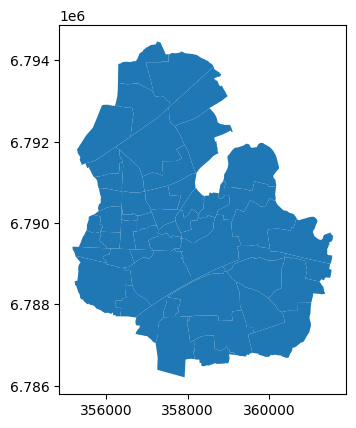

In [ ]:
#Chargement couche des Sections cadastrales

Sections= gpd.read_file("sections.zip", encoding='utf-8')
Sections.plot()
Sections.head(3)

id commune prefixe section numero  contenance     created  \
0  35051000AA0562   35051     000      AA    562     42655.0  2020-06-16   
1  35051000AA0564   35051     000      AA    564     21375.0  2020-06-16   
2  35051000AA0563   35051     000      AA    563      6378.0  2020-06-16   

      updated                                           geometry  
0  2023-03-28  POLYGON ((357147.131 6790343.595, 357174.713 6...  
1  2023-03-27  POLYGON ((357023.822 6790674.048, 357025.859 6...  
2  2022-01-28  POLYGON ((357515.617 6790355.263, 357541.619 6...

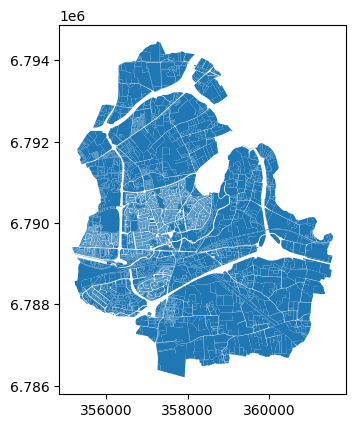

In [ ]:
#Chargement couche des Parcelles

Parcelles= gpd.read_file("parcelles.zip", encoding='utf-8')
Parcelles.plot()
Parcelles.head(3)

In [ ]:
#Compter le nombre de parcelles
len(Parcelles)

9162

commune   nom type     created     updated  \
0   35051  None   01  2020-06-16  2020-06-22   
1   35051  None   01  2020-06-16  2020-06-22   
2   35051  None   01  2020-06-16  2020-06-22   

                                            geometry  
0  POLYGON ((357222.008 6790493.977, 357213.758 6...  
1  POLYGON ((357187.130 6790473.351, 357193.638 6...  
2  POLYGON ((357208.471 6790399.177, 357213.178 6...

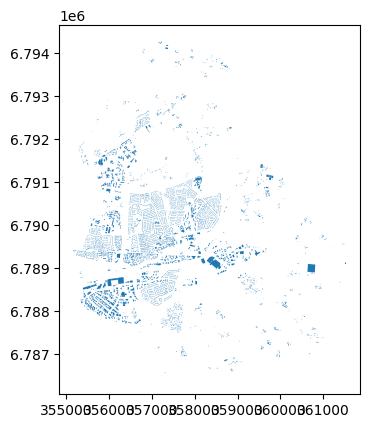

In [ ]:
#Chargement couche des Batiments

Batiments= gpd.read_file("batiments.zip", encoding='utf-8')
Batiments.plot()
Batiments.head(3)

In [ ]:
#Compter le nombre de batiments
len(Batiments)

9044

## Importation des données via l'API du GPU

--2024-03-19 08:39:39--  https://apicarto.ign.fr/api/gpu/zone-urba?partition=DU_243500139
Resolving apicarto.ign.fr (apicarto.ign.fr)... 57.128.40.173
Connecting to apicarto.ign.fr (apicarto.ign.fr)|57.128.40.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16346395 (16M) [application/json]
Saving to: ‘PLU.geojson’

PLU.geojson         100%[===================>]  15.59M  10.8MB/s    in 1.4s    

2024-03-19 08:39:46 (10.8 MB/s) - ‘PLU.geojson’ saved [16346395/16346395]



id     gid  \
0  zone_urba.fid--290cdf4c_18e55c529b6_1c1e  440146   
1  zone_urba.fid--290cdf4c_18e55c529b6_1c1f  463611   
2  zone_urba.fid--290cdf4c_18e55c529b6_1c20  463612   

                         gpu_doc_id  gpu_status             gpu_timestamp  \
0  337e5bcd3399cf123e31efe64e59893b  production 2023-05-02 22:30:13+00:00   
1  337e5bcd3399cf123e31efe64e59893b  production 2023-05-02 22:30:13+00:00   
2  337e5bcd3399cf123e31efe64e59893b  production 2023-05-02 22:30:13+00:00   

      partition  libelle libelong typezone destdomi  \
0  DU_243500139  UE2d(d)     None        U     None   
1  DU_243500139        A     None        A     None   
2  DU_243500139        A     None        A     None   

                             nomfic  \
0  243500139_reglement_20230406.pdf   
1  243500139_reglement_20230406.pdf   
2  243500139_reglement_20230406.pdf   

                                              urlfic insee datappro  datvalid  \
0  https://public.sig.rennesmetropole.fr/ressourc...  None     None  20230406   
1  https://public.sig.rennesmetropole.fr/ressourc...  None     None  20230406   
2  https://public.sig.rennesmetropole.fr/ressourc...  None     None  20230406   

                    idurba idzone lib_idzone  \
0  243500139_PLUI_20230406   None       None   
1  243500139_PLUI_20230406   None       None   
2  243500139_PLUI_20230406   None       None   

                                            geometry  
0  MULTIPOLYGON (((342890.712 6789273.203, 342933...  
1  MULTIPOLYGON (((336811.703 6791960.264, 336848...  
2  MULTIPOLYGON (((345067.640 6801093.030, 345095...

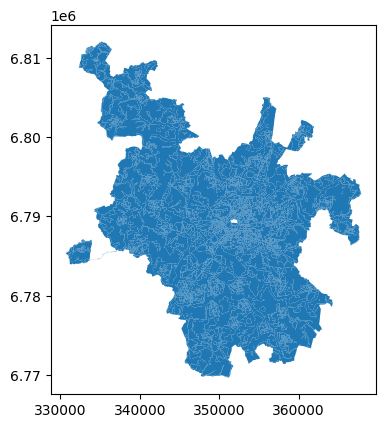

In [ ]:
#Importer le PLU de Rennes Métropole via l'API du GPU
!wget -O PLU.geojson https://apicarto.ign.fr/api/gpu/zone-urba?partition=DU_243500139

#Chargement couche du PLU
PLU= gpd.read_file("PLU.geojson", encoding='utf-8')
PLU = PLU.to_crs("EPSG:2154")
PLU.plot()
PLU.head(3)

## Préparation des couches

In [ ]:
# Vérifier le SCR des couches

Batiments.crs
Parcelles.crs
Sections.crs
PLU.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
#Créer un ID unique pour chaque batiment (id unique)

Batiments["ID_Bati"] = Batiments.index
Batiments.head()

commune   nom type     created     updated  \
0   35051  None   01  2020-06-16  2020-06-22   
1   35051  None   01  2020-06-16  2020-06-22   
2   35051  None   01  2020-06-16  2020-06-22   
3   35051  None   01  2020-06-16  2020-06-22   
4   35051  None   01  2020-06-16  2020-06-22   

                                            geometry  ID_Bati  \
0  POLYGON ((357222.008 6790493.977, 357213.758 6...        0   
1  POLYGON ((357187.130 6790473.351, 357193.638 6...        1   
2  POLYGON ((357208.471 6790399.177, 357213.178 6...        2   
3  POLYGON ((357201.063 6790536.791, 357202.418 6...        3   
4  POLYGON ((357170.131 6790496.341, 357177.821 6...        4   

   Surface_Batiment  
0               100  
1                92  
2               114  
3               139  
4               107

In [ ]:
# Créer un ID unique pour chaque parcelle (concaténation de deux champs)

Parcelles["ID_Parcelle"] = Parcelles["prefixe"] + "-" + Parcelles["section"] + "-" + Parcelles["numero"]
Parcelles.head(3)

id commune prefixe section numero  contenance     created  \
0  35051000AA0562   35051     000      AA    562     42655.0  2020-06-16   
1  35051000AA0564   35051     000      AA    564     21375.0  2020-06-16   
2  35051000AA0563   35051     000      AA    563      6378.0  2020-06-16   

      updated                                           geometry ID_Parcelle  \
0  2023-03-28  POLYGON ((357147.131 6790343.595, 357174.713 6...  000-AA-562   
1  2023-03-27  POLYGON ((357023.822 6790674.048, 357025.859 6...  000-AA-564   
2  2022-01-28  POLYGON ((357515.617 6790355.263, 357541.619 6...  000-AA-563   

   Surface_Parcelle  
0             42589  
1             23922  
2              5647

In [ ]:
# Créer un ID unique pour chaque section (concaténation de deux champs)

Sections["ID_Section"] = Sections["prefixe"] + "-" + Sections["code"]
Sections.head(3)

id commune prefixe code     created     updated  \
0  35051000AA   35051     000   AA  2020-06-16  2020-06-22   
1  35051000AB   35051     000   AB  2020-06-16  2020-06-22   
2  35051000AC   35051     000   AC  2020-06-16  2020-06-22   

                                            geometry ID_Section  \
0  POLYGON ((357095.719 6790338.898, 357089.990 6...     000-AA   
1  POLYGON ((357603.646 6790021.629, 357544.963 6...     000-AB   
2  POLYGON ((357841.087 6789716.194, 357850.289 6...     000-AC   

   Surface_Section  NbBatis  
0           369064      475  
1           214286      263  
2           142503      112

In [ ]:
# Ajouter une colonne surface aux sections cadastrales (entier)

Sections["Surface_Section"] = Sections['geometry'].area
Sections["Surface_Section"] = Sections["Surface_Section"].astype(int)
Sections.head(3)

id commune prefixe code     created     updated  \
0  35051000AA   35051     000   AA  2020-06-16  2020-06-22   
1  35051000AB   35051     000   AB  2020-06-16  2020-06-22   
2  35051000AC   35051     000   AC  2020-06-16  2020-06-22   

                                            geometry ID_Section  \
0  POLYGON ((357095.719 6790338.898, 357089.990 6...     000-AA   
1  POLYGON ((357603.646 6790021.629, 357544.963 6...     000-AB   
2  POLYGON ((357841.087 6789716.194, 357850.289 6...     000-AC   

   Surface_Section  NbBatis  
0           369064      475  
1           214286      263  
2           142503      112

In [ ]:
# Ajouter une colonne surface aux parcelles cadastrales (entier)

Parcelles["Surface_Parcelle"] = Parcelles['geometry'].area
Parcelles["Surface_Parcelle"] = Parcelles["Surface_Parcelle"].astype(int)
Parcelles.head(3)

id commune prefixe section numero  contenance     created  \
0  35051000AA0562   35051     000      AA    562     42655.0  2020-06-16   
1  35051000AA0564   35051     000      AA    564     21375.0  2020-06-16   
2  35051000AA0563   35051     000      AA    563      6378.0  2020-06-16   

      updated                                           geometry ID_Parcelle  \
0  2023-03-28  POLYGON ((357147.131 6790343.595, 357174.713 6...  000-AA-562   
1  2023-03-27  POLYGON ((357023.822 6790674.048, 357025.859 6...  000-AA-564   
2  2022-01-28  POLYGON ((357515.617 6790355.263, 357541.619 6...  000-AA-563   

   Surface_Parcelle  
0             42589  
1             23922  
2              5647

In [ ]:
# Ajouter une colonne surface aux batiments

Batiments["Surface_Batiment"] = Batiments['geometry'].area
Batiments["Surface_Batiment"] = Batiments["Surface_Batiment"].astype(int)
Batiments.head(3)

commune   nom type     created     updated  \
0   35051  None   01  2020-06-16  2020-06-22   
1   35051  None   01  2020-06-16  2020-06-22   
2   35051  None   01  2020-06-16  2020-06-22   

                                            geometry  ID_Bati  \
0  POLYGON ((357222.008 6790493.977, 357213.758 6...        0   
1  POLYGON ((357187.130 6790473.351, 357193.638 6...        1   
2  POLYGON ((357208.471 6790399.177, 357213.178 6...        2   

   Surface_Batiment  
0               100  
1                92  
2               114

<Axes: >

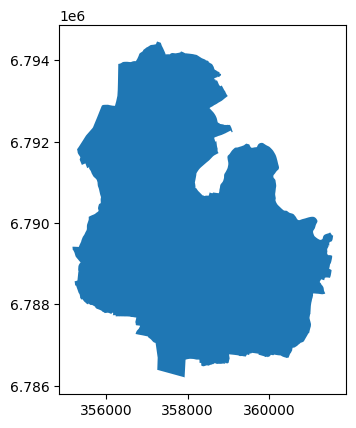

In [ ]:
# Créer une couche avec l'emprise de la commune d'étude

Contours = Sections.dissolve(by="commune")
Contours.plot()

<Axes: >

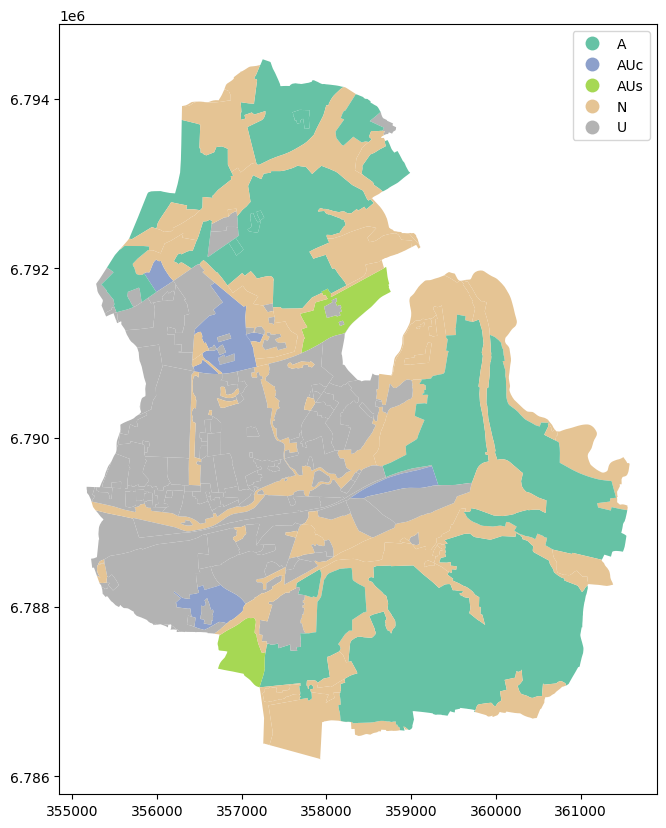

In [ ]:
#Ne garder sur le PLU de la commune
PLUCommune = gpd.overlay(PLU, Contours, how='intersection')
PLUCommune.plot(figsize=(10,10),column='typezone', legend=True, cmap='Set2')


## Analyse spatiale

*   Compter le nombre de bâtiments par section cadastrale
*   Compter le nombre de bâtiments par parcelle cadastrale
*   Calculer la proportion de surface des bâtiments par parcelle cadastrale
*   Compter le nombre de parcelles par type de zonage
*   Compter le nombre de bâtiments par type de zonage

### Compter le nombre de bâtiments par section cadastrale


commune   nom type     created     updated                        geometry  \
0   35051  None   01  2020-06-16  2020-06-22  POINT (357214.927 6790493.368)   
1   35051  None   01  2020-06-16  2020-06-22  POINT (357186.831 6790466.391)   
2   35051  None   01  2020-06-16  2020-06-22  POINT (357216.900 6790398.322)   

   ID_Bati  Surface_Batiment  
0        0               100  
1        1                92  
2        2               114

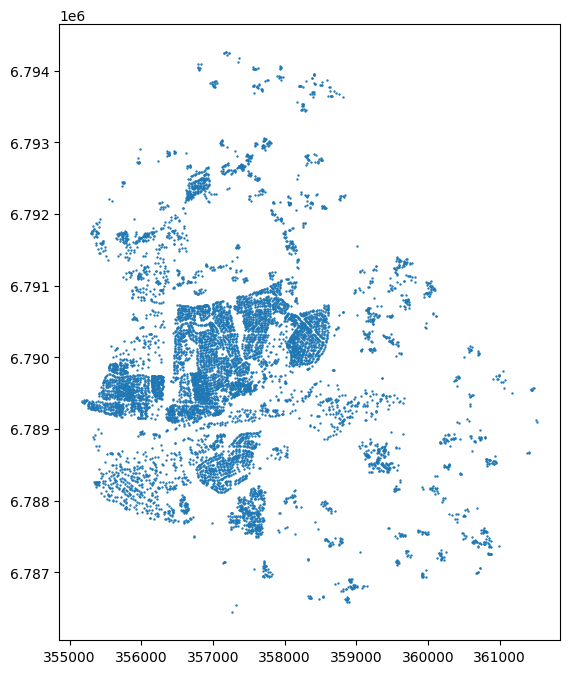

In [ ]:
#Transformer les batiments (polygones) en points (centroides)

BatimentsCentro = Batiments.copy()
BatimentsCentro.geometry = BatimentsCentro['geometry'].centroid
BatimentsCentro.crs =Batiments.crs
BatimentsCentro.plot(figsize=(8,8), markersize=0.5, legend=True)
BatimentsCentro.head(3)

In [ ]:
# Encrichir les batiments des informations de la couche des Sections Cadastrales (jointure spatiale)

BatimentsEtape1 = gpd.sjoin(BatimentsCentro, Sections)
BatimentsEtape1.head(5)

commune_left   nom type created_left updated_left  \
0        35051  None   01   2020-06-16   2020-06-22   
1        35051  None   01   2020-06-16   2020-06-22   
2        35051  None   01   2020-06-16   2020-06-22   
3        35051  None   01   2020-06-16   2020-06-22   
4        35051  None   01   2020-06-16   2020-06-22   

                         geometry  ID_Bati  Surface_Batiment  index_right  \
0  POINT (357214.927 6790493.368)        0               100            0   
1  POINT (357186.831 6790466.391)        1                92            0   
2  POINT (357216.900 6790398.322)        2               114            0   
3  POINT (357196.770 6790531.821)        3               139            0   
4  POINT (357176.881 6790496.643)        4               107            0   

           id commune_right prefixe code created_right updated_right  \
0  35051000AA         35051     000   AA    2020-06-16    2020-06-22   
1  35051000AA         35051     000   AA    2020-06-16    2020-06-22   
2  35051000AA         35051     000   AA    2020-06-16    2020-06-22   
3  35051000AA         35051     000   AA    2020-06-16    2020-06-22   
4  35051000AA         35051     000   AA    2020-06-16    2020-06-22   

  ID_Section  Surface_Section  
0     000-AA           369064  
1     000-AA           369064  
2     000-AA           369064  
3     000-AA           369064  
4     000-AA           369064

In [ ]:
#Réorganiser la table

BatimentsEtape2 = BatimentsEtape1[["ID_Bati", "type", "code", "Surface_Batiment", "ID_Section", "Surface_Section", "geometry"]]
BatimentsEtape2.head(3)

ID_Bati type code  Surface_Batiment ID_Section  Surface_Section  \
0        0   01   AA               100     000-AA           369064   
1        1   01   AA                92     000-AA           369064   
2        2   01   AA               114     000-AA           369064   

                         geometry  
0  POINT (357214.927 6790493.368)  
1  POINT (357186.831 6790466.391)  
2  POINT (357216.900 6790398.322)

In [ ]:
# Encrichir les batiments des informations de la couche des parcelles Cadastrales (jointure spatiale)

BatimentsEtape3 = gpd.sjoin(BatimentsEtape2, Parcelles)
BatimentsEtape3.head(3)

ID_Bati type code  Surface_Batiment ID_Section  Surface_Section  \
0        0   01   AA               100     000-AA           369064   
1        1   01   AA                92     000-AA           369064   
2        2   01   AA               114     000-AA           369064   

                         geometry  index_right              id commune  \
0  POINT (357214.927 6790493.368)           15  35051000AA0126   35051   
1  POINT (357186.831 6790466.391)           14  35051000AA0124   35051   
2  POINT (357216.900 6790398.322)           22  35051000AA0119   35051   

  prefixe section numero  contenance     created     updated ID_Parcelle  \
0     000      AA    126       580.0  2020-06-16  2022-01-28  000-AA-126   
1     000      AA    124       468.0  2020-06-16  2022-01-28  000-AA-124   
2     000      AA    119       513.0  2020-06-16  2022-01-28  000-AA-119   

   Surface_Parcelle  
0               584  
1               470  
2               511

In [ ]:
#Réorganiser la table

BatimentsFinal = BatimentsEtape3[["ID_Bati", "type", "code", "Surface_Batiment", "ID_Section", "Surface_Section", "ID_Parcelle", "Surface_Parcelle", "geometry"]]
BatimentsFinal.head(3)

ID_Bati type code  Surface_Batiment ID_Section  Surface_Section  \
0        0   01   AA               100     000-AA           369064   
1        1   01   AA                92     000-AA           369064   
2        2   01   AA               114     000-AA           369064   

  ID_Parcelle  Surface_Parcelle                        geometry  
0  000-AA-126               584  POINT (357214.927 6790493.368)  
1  000-AA-124               470  POINT (357186.831 6790466.391)  
2  000-AA-119               511  POINT (357216.900 6790398.322)

In [ ]:
# Jointure attributaire pour repasser sur la couche des polygones

BatimentsFinalOk = Batiments.merge(BatimentsFinal, on='ID_Bati')
BatimentsFinalOk.head(3)

commune   nom type_x     created     updated  \
0   35051  None     01  2020-06-16  2020-06-22   
1   35051  None     01  2020-06-16  2020-06-22   
2   35051  None     01  2020-06-16  2020-06-22   

                                          geometry_x  ID_Bati  \
0  POLYGON ((357222.008 6790493.977, 357213.758 6...        0   
1  POLYGON ((357187.130 6790473.351, 357193.638 6...        1   
2  POLYGON ((357208.471 6790399.177, 357213.178 6...        2   

   Surface_Batiment_x type_y code  Surface_Batiment_y ID_Section  \
0                 100     01   AA                 100     000-AA   
1                  92     01   AA                  92     000-AA   
2                 114     01   AA                 114     000-AA   

   Surface_Section ID_Parcelle  Surface_Parcelle  \
0           369064  000-AA-126               584   
1           369064  000-AA-124               470   
2           369064  000-AA-119               511   

                       geometry_y  
0  POINT (357214.927 6790493.368)  
1  POINT (357186.831 6790466.391)  
2  POINT (357216.900 6790398.322)

In [ ]:
#Réorganiser la table
BatimentsFinalOk = BatimentsFinalOk[["ID_Bati", "type_x", "Surface_Batiment_x", "ID_Section", "Surface_Section", "ID_Parcelle", "Surface_Parcelle", "geometry_x"]]
BatimentsFinalOk.rename(columns={'type_x': 'type','Surface_Batiment_x': 'Surface_Batiment','geometry_x': 'Geometry'}, inplace=True)
BatimentsFinalOk.head()

<ipython-input-25-545e0da0ae41>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BatimentsFinalOk.rename(columns={'type_x': 'type','Surface_Batiment_x': 'Surface_Batiment','geometry_x': 'Geometry'}, inplace=True)


ID_Bati type  Surface_Batiment ID_Section  Surface_Section ID_Parcelle  \
0        0   01               100     000-AA           369064  000-AA-126   
1        1   01                92     000-AA           369064  000-AA-124   
2        2   01               114     000-AA           369064  000-AA-119   
3        3   01               139     000-AA           369064   000-AA-78   
4        4   01               107     000-AA           369064   000-AA-82   

   Surface_Parcelle                                           Geometry  
0               584  POLYGON ((357222.008 6790493.977, 357213.758 6...  
1               470  POLYGON ((357187.130 6790473.351, 357193.638 6...  
2               511  POLYGON ((357208.471 6790399.177, 357213.178 6...  
3               669  POLYGON ((357201.063 6790536.791, 357202.418 6...  
4               577  POLYGON ((357170.131 6790496.341, 357177.821 6...

ID_Bati type  Surface_Batiment ID_Section  Surface_Section ID_Parcelle  \
0        0   01               100     000-AA           369064  000-AA-126   
1        1   01                92     000-AA           369064  000-AA-124   
2        2   01               114     000-AA           369064  000-AA-119   

   Surface_Parcelle                                           Geometry  
0               584  POLYGON ((357222.008 6790493.977, 357213.758 6...  
1               470  POLYGON ((357187.130 6790473.351, 357193.638 6...  
2               511  POLYGON ((357208.471 6790399.177, 357213.178 6...

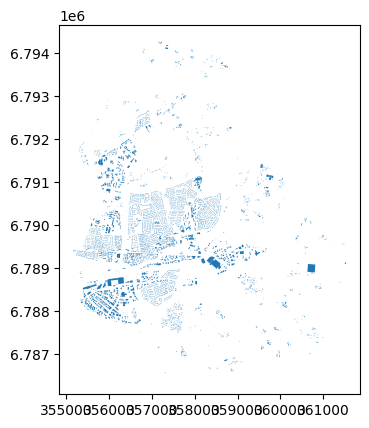

In [ ]:
#Repasser en GeoDataframe

BatiOK = gpd.GeoDataFrame(BatimentsFinalOk, crs="EPSG:2154", geometry='Geometry')
BatiOK.plot()
BatiOK.head(3)


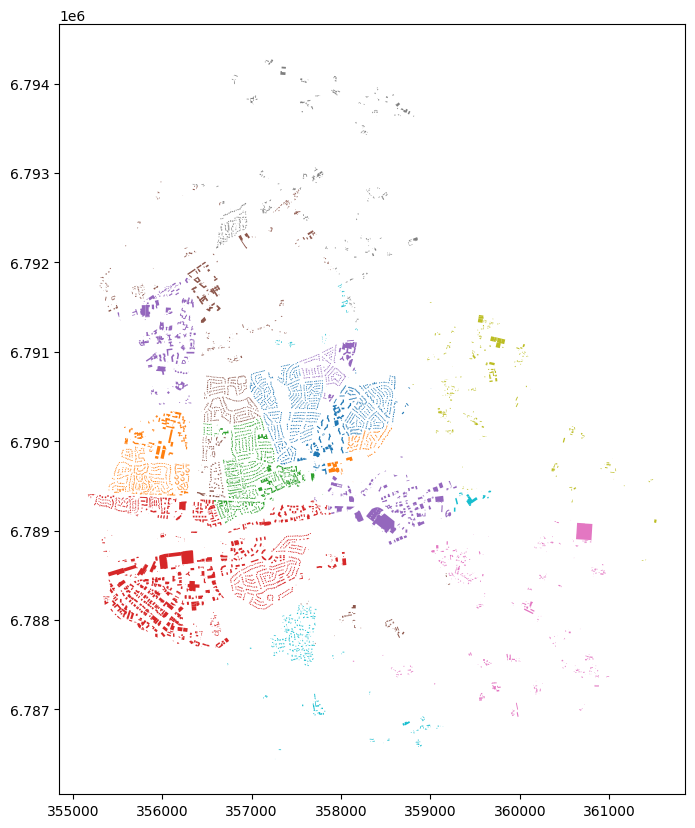

In [ ]:
# Faire une carte des batiments catégorisée par code de section

map2 = BatiOK.plot(figsize=(10,10), column='ID_Section', legend=False).get_figure()

In [ ]:
# Calculer le  nombre de batiments par sections cadastrale

NbBatiSection = BatiOK[["ID_Section", "ID_Bati"]].groupby("ID_Section").size()
NbBatiSection = pd.DataFrame(NbBatiSection)
NbBatiSection = NbBatiSection.rename(columns={0: 'NbBatis'})
NbBatiSection.head(3)

NbBatis
ID_Section         
000-AA          475
000-AB          263
000-AC          112

In [ ]:
# Compter le nombre de batiment (vérification)

total1 = Batiments['geometry'].count()
total2 = NbBatiSection['NbBatis'].sum()
print(total1)
print(total1)

9044
9044


In [ ]:
# Jointure attributaire pour repasser sur la couche des sections cadastrales

Sections = Sections.merge(NbBatiSection, on='ID_Section')
Sections.head(3)

id commune prefixe code     created     updated  \
0  35051000AA   35051     000   AA  2020-06-16  2020-06-22   
1  35051000AB   35051     000   AB  2020-06-16  2020-06-22   
2  35051000AC   35051     000   AC  2020-06-16  2020-06-22   

                                            geometry ID_Section  \
0  POLYGON ((357095.719 6790338.898, 357089.990 6...     000-AA   
1  POLYGON ((357603.646 6790021.629, 357544.963 6...     000-AB   
2  POLYGON ((357841.087 6789716.194, 357850.289 6...     000-AC   

   Surface_Section  NbBatis  
0           369064      475  
1           214286      263  
2           142503      112

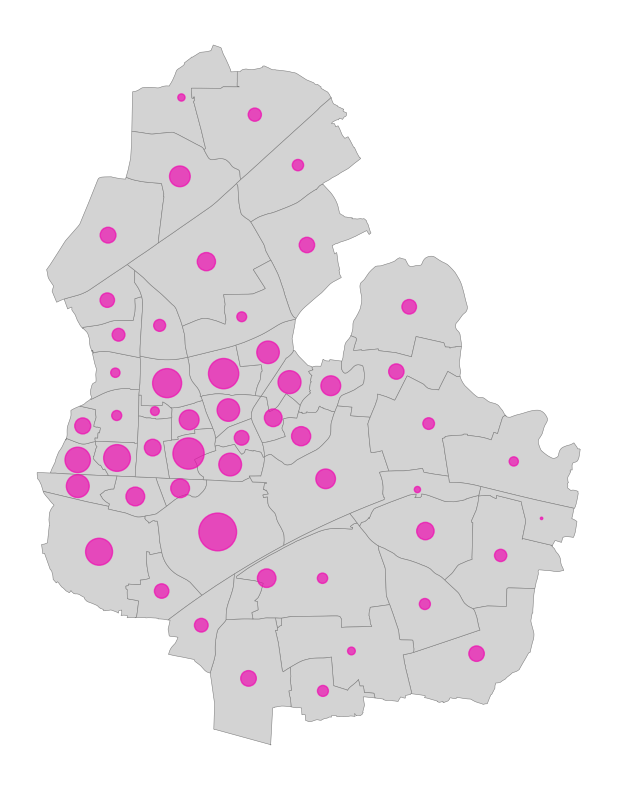

In [ ]:
# Faire une carte pour représenter le nombre de batiments pas section cadastrale

SectionsCentro = Sections.copy()
SectionsCentro.geometry = SectionsCentro['geometry'].centroid

Carte1, ax = plt.subplots(figsize=(10,10))  # Configuration de la carte

Sections.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.4)
SectionsCentro.plot(ax=ax,color="#ee0db1", markersize="NbBatis",alpha=0.7, categorical=False, legend=True)

ax.axis("off")
plt.show()

<Axes: ylabel='Frequency'>

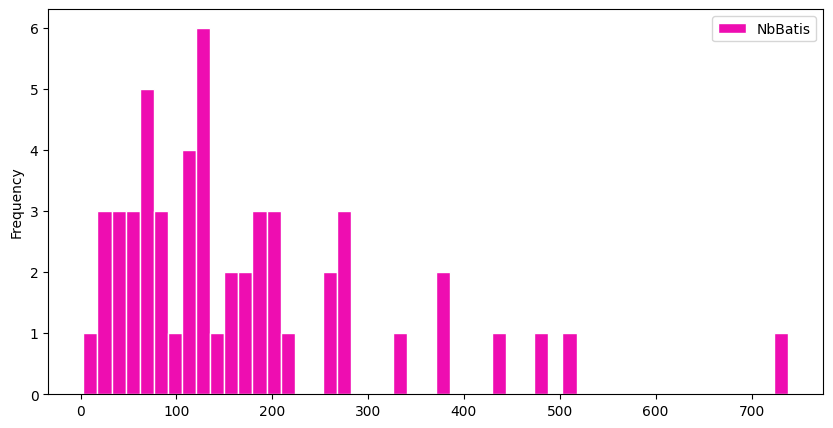

In [ ]:
# Histogramme

NbBatiSection.plot.hist(figsize = (10,5), bins=50, color="#ee0db1", edgecolor='white')

### Compter le nombre de bâtiments par parcelle cadastrale

In [ ]:
# Calculer le Nombre de batiments par parcelle cadastrale

NbBatiParcelle  = BatiOK[["ID_Parcelle", "ID_Bati"]].groupby("ID_Parcelle").size()
NbBatiParcelle =pd.DataFrame(NbBatiParcelle)
NbBatiParcelle = NbBatiParcelle.rename(columns={0: 'NbBatis'})
NbBatiParcelle.head(5)

NbBatis
ID_Parcelle         
000-AA-10          2
000-AA-100         1
000-AA-101         1
000-AA-102         1
000-AA-103         1

In [ ]:
# Compter le nombre de batiment

total1 = Batiments['geometry'].count()
total2 = NbBatiParcelle['NbBatis'].sum()
print(total1)
print(total1)

9044
9044


In [ ]:
# Jointure attributaire pour repasser sur la couche des parcelles  cadastrales

Parcellesbis = Parcelles.merge(NbBatiParcelle, on='ID_Parcelle')
Parcellesbis.head(3)

id commune prefixe section numero  contenance     created  \
0  35051000AA0562   35051     000      AA    562     42655.0  2020-06-16   
1  35051000AA0192   35051     000      AA    192      6752.0  2020-06-16   
2  35051000AA0059   35051     000      AA     59       619.0  2020-06-16   

      updated                                           geometry ID_Parcelle  \
0  2023-03-28  POLYGON ((357147.131 6790343.595, 357174.713 6...  000-AA-562   
1  2022-01-28  POLYGON ((357526.866 6790865.979, 357527.840 6...  000-AA-192   
2  2022-01-28  POLYGON ((357024.044 6790482.974, 357016.068 6...   000-AA-59   

   Surface_Parcelle  NbBatis  
0             42589        1  
1              6609        1  
2               621        1

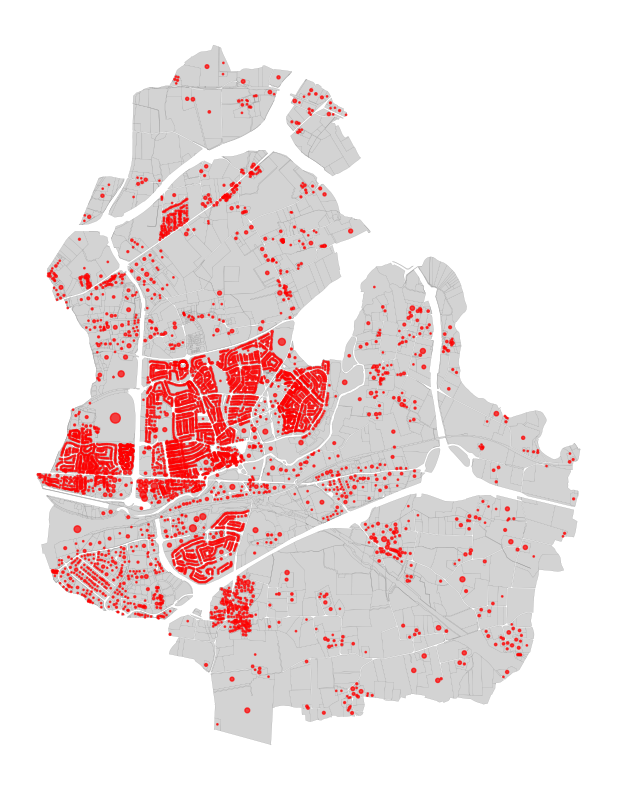

In [ ]:
# Faire une carte pour représenter le nombre de batiments par parcelle cadastrale

Parcellescentro = Parcellesbis.copy()
Parcellescentro.geometry = Parcellescentro['geometry'].centroid

Carte1, ax = plt.subplots(figsize=(10,10))  # Configuration de la carte

Parcelles.plot(ax=ax, color="lightgray", edgecolor="grey", linewidth=0.1)
Parcellescentro.plot(ax=ax, markersize="NbBatis", color='red', alpha=0.7, legend=True)

ax.axis("off")
plt.show()

<Axes: ylabel='Frequency'>

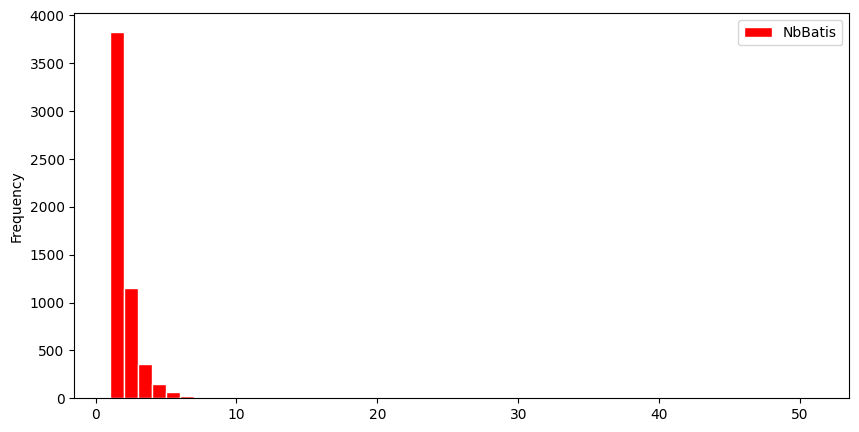

In [ ]:
#Histogramme

NbBatiParcelle.plot.hist(figsize = (10,5), bins=50, color='red', edgecolor='white')

### Calculer la proportion de surface des bâtiments par parcelle cadastrale (tx de recouvrement)

In [ ]:
BatiOK.head(3)

ID_Bati type  Surface_Batiment ID_Section  Surface_Section ID_Parcelle  \
0        0   01               100     000-AA           369064  000-AA-126   
1        1   01                92     000-AA           369064  000-AA-124   
2        2   01               114     000-AA           369064  000-AA-119   

   Surface_Parcelle                                           Geometry  
0               584  POLYGON ((357222.008 6790493.977, 357213.758 6...  
1               470  POLYGON ((357187.130 6790473.351, 357193.638 6...  
2               511  POLYGON ((357208.471 6790399.177, 357213.178 6...

In [ ]:
# Calculer la proportion des surfaces baties par parcelle cadastrale

recap = BatiOK.groupby('ID_Parcelle').agg({'Surface_Batiment':'sum','Surface_Parcelle':'max'})
recap["propbatiparcelle"] = recap["Surface_Batiment"] / recap["Surface_Parcelle"] *100
recap.head()

Surface_Batiment  Surface_Parcelle  propbatiparcelle
ID_Parcelle                                                      
000-AA-10                  99               796         12.437186
000-AA-100                 84               421         19.952494
000-AA-101                139               644         21.583851
000-AA-102                111               528         21.022727
000-AA-103                 91               606         15.016502

In [ ]:
# Faire la jointure attributaire avec la couche des parcelles cadastrales et la carte

Parcellesok = Parcellesbis.merge(recap, on='ID_Parcelle')
Parcellesok.head()

id commune prefixe section numero  contenance     created  \
0  35051000AA0562   35051     000      AA    562     42655.0  2020-06-16   
1  35051000AA0192   35051     000      AA    192      6752.0  2020-06-16   
2  35051000AA0059   35051     000      AA     59       619.0  2020-06-16   
3  35051000AA0553   35051     000      AA    553      1290.0  2020-06-16   
4  35051000AA0137   35051     000      AA    137       610.0  2020-06-16   

      updated                                           geometry ID_Parcelle  \
0  2023-03-28  POLYGON ((357147.131 6790343.595, 357174.713 6...  000-AA-562   
1  2022-01-28  POLYGON ((357526.866 6790865.979, 357527.840 6...  000-AA-192   
2  2022-01-28  POLYGON ((357024.044 6790482.974, 357016.068 6...   000-AA-59   
3  2022-01-28  POLYGON ((357028.302 6790578.606, 357025.147 6...  000-AA-553   
4  2022-01-28  POLYGON ((357264.528 6790536.956, 357247.448 6...  000-AA-137   

   Surface_Parcelle_x  NbBatis  Surface_Batiment  Surface_Parcelle_y  \
0               42589        1                 8               42589   
1                6609        1                 7                6609   
2                 621        1               125                 621   
3                1287        2               433                1287   
4                 609        1               140                 609   

   propbatiparcelle  
0          0.018784  
1          0.105916  
2         20.128824  
3         33.644134  
4         22.988506

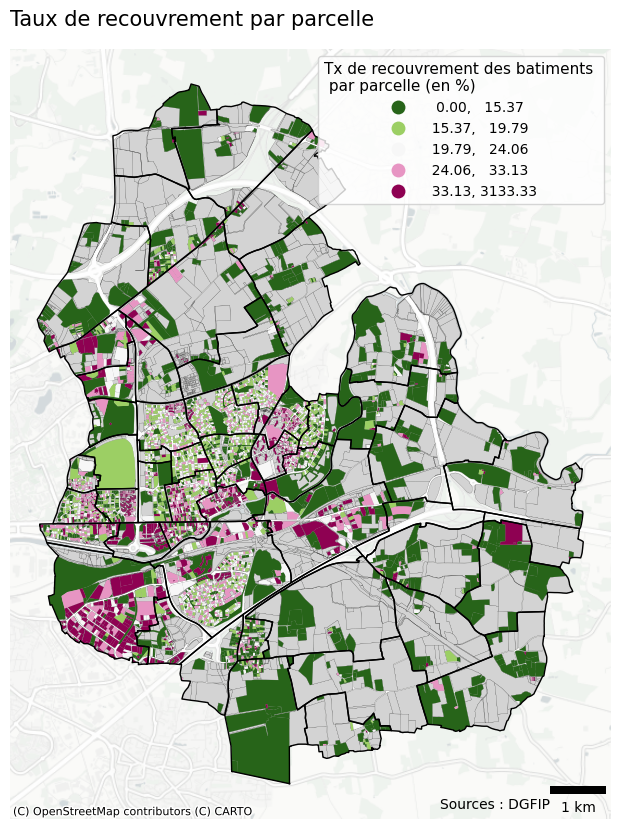

In [ ]:
Carte1, ax = plt.subplots(figsize=(10,10))

Sections.to_crs('EPSG:3857').boundary.plot(ax=ax, edgecolor="black", linewidth=1)
Parcelles.to_crs('EPSG:3857').plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.1)
Parcellesok.to_crs('EPSG:3857').plot(ax=ax, column='propbatiparcelle', cmap='PiYG_r', scheme='quantiles', legend=True,
                                     legend_kwds={'title': "Tx de recouvrement des batiments \n par parcelle (en %)", 'loc': 'upper right', 'title_fontsize': 11, 'fontsize': 10})

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

ax.axis("off")
plt.title('Taux de recouvrement du bati par parcelle', loc='left', fontsize=15)
ax.text(0.90, 0.01, 'Sources : DGFIP', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=10)
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="black"))

plt.show()

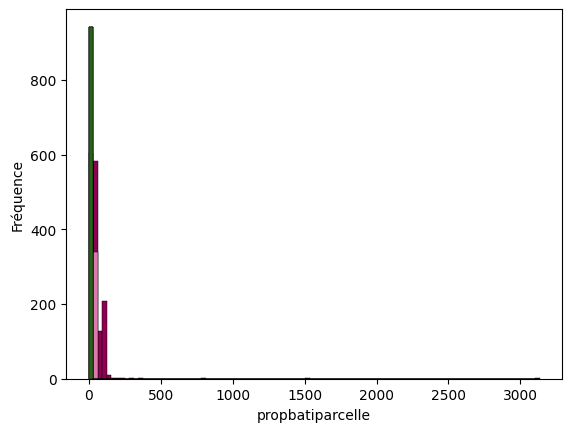

In [ ]:
# Histogramme en fonction de la discrétisation de la carte

import seaborn as sns

# Nombre de quantiles
num_quantiles = 6

# Calculer les quantiles
quantiles = pd.qcut(Parcellesok['propbatiparcelle'], num_quantiles, labels=False)

# Tracer l'histogramme avec des couleurs de quantiles en utilisant Seaborn
sns.histplot(data=Parcellesok, x='propbatiparcelle', bins=100, hue=quantiles, palette='PiYG_r',  alpha=1, legend=False)

# Définir les étiquettes des axes
plt.xlabel("propbatiparcelle")
plt.ylabel("Fréquence")

# Afficher le graphe
plt.show()

### Compter le nombre de parcelles par type de zonage

id commune prefixe_left section numero  contenance  \
0  35051000AA0562   35051          000      AA    562     42655.0   
1  35051000AA0564   35051          000      AA    564     21375.0   

  created_left updated_left  \
0   2020-06-16   2023-03-28   
1   2020-06-16   2023-03-27   

                                            geometry ID_Parcelle  ...  idzone  \
0  POLYGON ((357147.131 6790343.595, 357174.713 6...  000-AA-562  ...    None   
1  POLYGON ((357023.822 6790674.048, 357025.859 6...  000-AA-564  ...    None   

   lib_idzone        id_2  prefixe_right code created_right updated_right  \
0        None  35051000AA            000   AA    2020-06-16    2020-06-22   
1        None  35051000AA            000   AA    2020-06-16    2020-06-22   

  ID_Section Surface_Section NbBatis  
0     000-AA          369064     475  
1     000-AA          369064     475  

[2 rows x 38 columns]

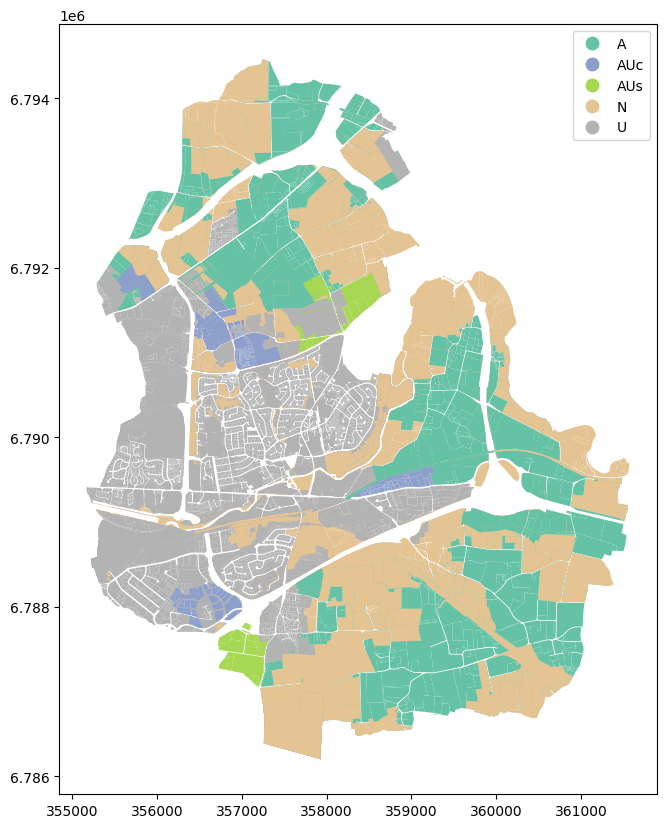

In [ ]:
# Encrichir les batiments des informations de la couche PLU (jointure spatiale)

ParcellesPLU = gpd.sjoin(Parcelles, PLUCommune)
ParcellesPLU.plot(figsize=(10,10),column='typezone', legend=True, cmap='Set2')
ParcellesPLU.head(2)

id
typezone      
A         1306
AUc        436
AUs         89
N         1737
U         8257

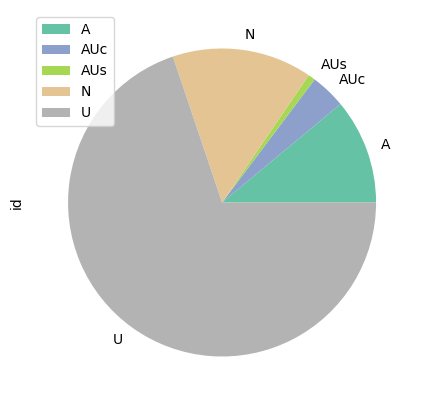

In [ ]:
# Graphique du nombre de parcelles par zonage

Categorie = ParcellesPLU[["typezone", "id"]].groupby("typezone").count()
Categorie.plot.pie(figsize =(14,5), y="id", cmap='Set2')
Categorie.head()

### Compter le nombre de bâtiments par type de zonage

In [ ]:
# Encrichir les batiments des informations de la couche PLU (jointure spatiale)

BatimentsPLU = gpd.sjoin(Batiments, PLUCommune)
BatimentsPLU.plot(figsize=(10,10),column='typezone', legend=True, cmap='Set2')
BatimentsPLU.head(2)

In [ ]:
# Graphique du nombre de bâtiments par zonage

Categorie = BatimentsPLU[["typezone", "ID_Bati"]].groupby("typezone").count()
Categorie.plot.pie(figsize =(14,5), y="ID_Bati", cmap='Set2')
Categorie.head()


## Cartographie du risque d'innondation

### Préparation des couches

In [ ]:
#Téléchargement des datas depuis le portail opendata de Rennes
!wget -O hydrographie.geojson https://data.rennesmetropole.fr/explore/dataset/reseau_hydrographique/download/?format=geojson&timezone=Europe/Berlin&lang=fr

--2024-03-19 08:54:41--  https://data.rennesmetropole.fr/explore/dataset/reseau_hydrographique/download/?format=geojson
Resolving data.rennesmetropole.fr (data.rennesmetropole.fr)... 34.249.199.226, 34.248.20.69
Connecting to data.rennesmetropole.fr (data.rennesmetropole.fr)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘hydrographie.geojson’

hydrographie.geojso     [              <=>   ]  16.48M  3.32MB/s    in 5.0s    

2024-03-19 08:54:47 (3.32 MB/s) - ‘hydrographie.geojson’ saved [17284736]



gml_id  hydro_code_insee  deno_hydro_id  objectid  type_hydro_id  \
0  v_hydro.1112           35099.0            1.0      1112              5   
1  v_hydro.1161           35069.0            1.0      1161              2   
2  v_hydro.1706           35206.0            1.0      1706              2   

  type_hydro_nom deno_hydr_nom  ope_id hydro_date_maj  hydro_visible  \
0       ruisseau          None     1.0            NaT              1   
1          étang          None     1.0            NaT              1   
2          étang          None     1.0            NaT              1   

                                            geometry  
0  POLYGON ((357989.641 6771175.078, 357995.861 6...  
1  POLYGON ((358227.898 6785710.503, 358205.337 6...  
2  POLYGON ((360845.295 6775964.375, 360845.121 6...

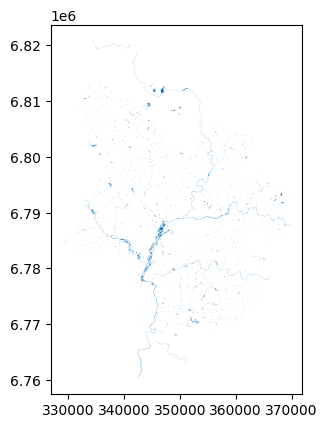

In [ ]:
#Chargement couche hydrographie

Hydrographie= gpd.read_file("hydrographie.geojson", encoding='utf-8')
Hydrographie = Hydrographie.to_crs("EPSG:2154")
Hydrographie.plot()
Hydrographie.head(3)

<Axes: >

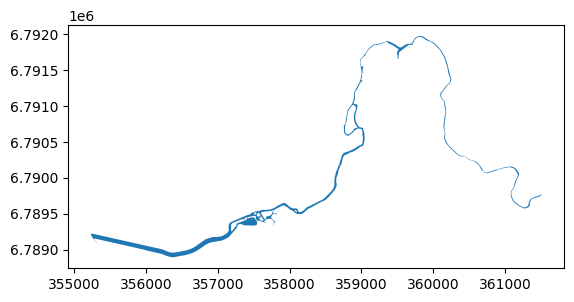

In [ ]:
# Ne garder que les troncons de type "fleuve" dans la commune d'étude

Fleuve = Hydrographie[(Hydrographie["type_hydro_nom"] == 'fleuve')]
Hydrocommunetrace = gpd.overlay(Fleuve, Contours, how='intersection')
Hydrocommunetrace.plot()

<Axes: >

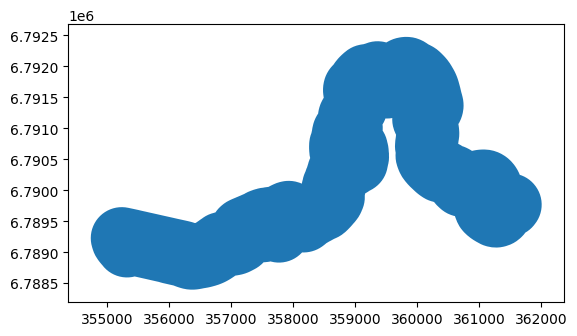

In [ ]:
#Faire un buffer de 500m autour de la couche hydro
Hydrocommune = Hydrocommunetrace.copy()
Hydrocommune['geometry'] = Hydrocommune['geometry'].buffer(500)
Hydrocommune = Hydrocommune.dissolve(by ='deno_hydr_nom')
Hydrocommune.plot()

<Axes: >

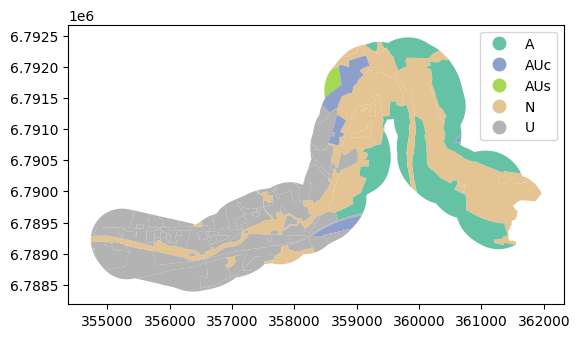

In [ ]:
# Garder le zonage situés à moins de 500m de la Vilaine
Zonagerisque = gpd.overlay(PLU, Hydrocommune, how='intersection')
Zonagerisque.plot(column = 'typezone', legend = True, cmap='Set2')

<Axes: >

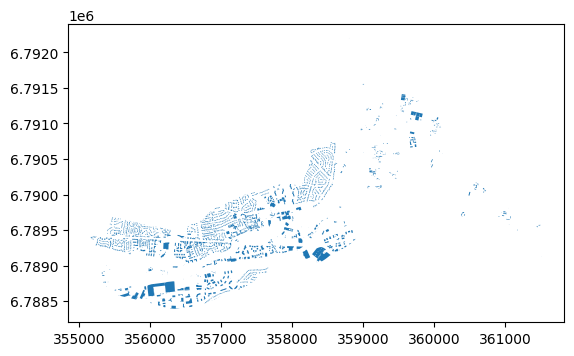

In [ ]:
# Garder les bâtiments situés à moins de 500m de la Vilaine

Batirisque = gpd.overlay(Batiments, Hydrocommune, how='intersection')
Batirisque.plot()

### Cartographie

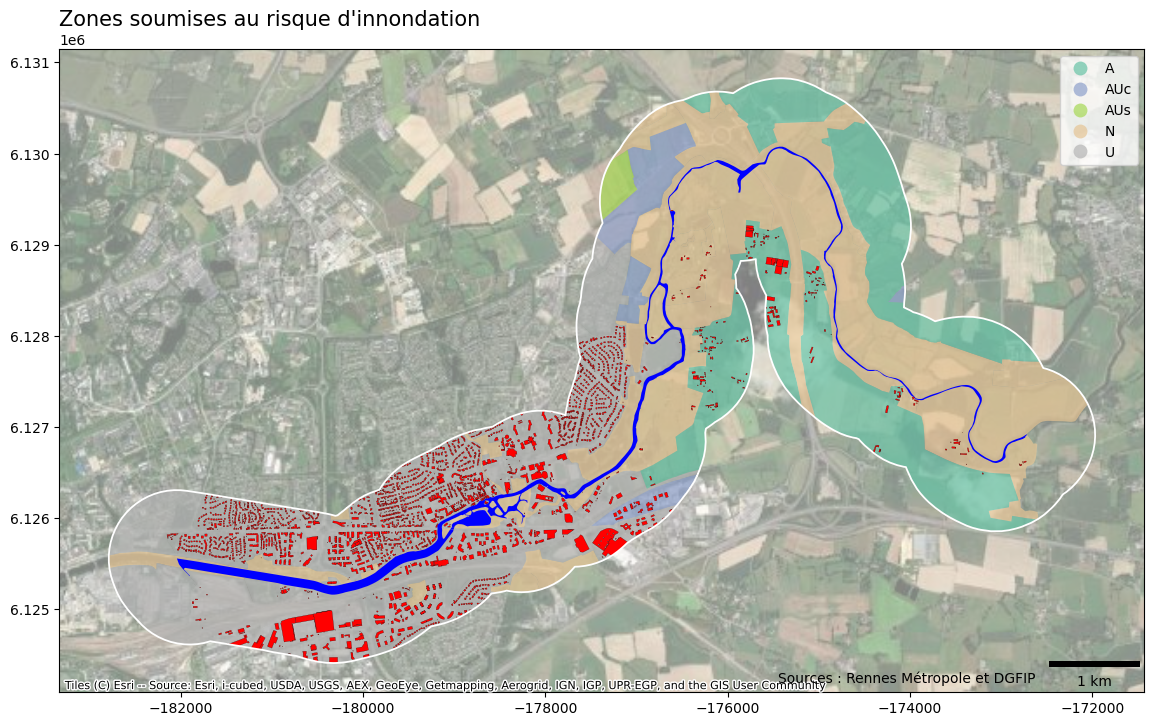

In [ ]:
#Carte récapitulative

Carte1, ax = plt.subplots(figsize=(14,14))
Hydrocommune.boundary.to_crs('EPSG:3857').plot(ax=ax, edgecolor="white", linewidth=1.3)
Zonagerisque.to_crs('EPSG:3857').plot(ax = ax, column = 'typezone', legend = True, alpha=0.7, cmap='Set2')
Batirisque.to_crs('EPSG:3857').plot(ax=ax, color="red", edgecolor="black", linewidth=0.15)
Hydrocommunetrace.to_crs('EPSG:3857').plot(ax=ax, color="blue",linewidth=5)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

plt.title("Zones soumises au risque d'innondation", loc='left', fontsize=15)
ax.text(0.90, 0.01, 'Sources : Rennes Métropole et DGFIP', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=10)
ax.add_artist(ScaleBar(1, length_fraction=0.1, location="lower right", box_alpha=0, color="black"))

plt.show()

# Applicatif : indicateur d'urbanisation à l'échelle d'un département

### Préparation des données


In [ ]:
#Téléchargement des datas depuis cadastre.data.gouv

!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/batiments -O batiments.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/communes -O communes.zip
!wget https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/sections -O sections.zip

--2024-03-18 12:21:45--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/batiments
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16322835 (16M) [application/x-shapefile]
Saving to: ‘batiments.zip’

batiments.zip       100%[===================>]  15.57M  8.79MB/s    in 1.8s    

2024-03-18 12:21:48 (8.79 MB/s) - ‘batiments.zip’ saved [16322835/16322835]

--2024-03-18 12:21:48--  https://cadastre.data.gouv.fr/bundler/cadastre-etalab/departements/05/shp/communes
Resolving cadastre.data.gouv.fr (cadastre.data.gouv.fr)... 54.36.212.78
Connecting to cadastre.data.gouv.fr (cadastre.data.gouv.fr)|54.36.212.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2052243 (2.0M) [application/x-shapefile]
Saving to: ‘communes.zip’

communes.zip        100%[===================>]   1

In [ ]:
#Chargement couche batiment (environ 3mn)
batiments= gpd.read_file("batiments.zip")
batiments.head(3)

commune   nom type     created     updated  \
0   05003  None   02  2006-11-26  2014-02-14   
1   05003  None   01  2006-11-13  2014-02-14   
2   05003  None   01  2015-01-29  2015-01-29   

                                            geometry  
0  POLYGON ((1004394.633 6419015.473, 1004395.489...  
1  POLYGON ((1004471.541 6418962.558, 1004471.602...  
2  POLYGON ((1004472.347 6418979.767, 1004472.941...

In [ ]:
batiments['commune'].count()

168340

In [ ]:
#Chargement couche communes
communes= gpd.read_file("communes.zip", encoding='utf-8')
communes.head(3)

id               nom     created     updated  \
0  05003         AIGUILLES  2006-12-14  2017-03-17   
1  05018  LA BATIE-VIEILLE  2007-03-09  2019-07-02   
2  05025          BUISSARD  2008-04-17  2022-03-09   

                                            geometry  
0  POLYGON ((1009588.427 6411890.754, 1009510.401...  
1  POLYGON ((950898.468 6385985.734, 950894.352 6...  
2  POLYGON ((950232.638 6399301.150, 950040.131 6...

In [ ]:
len(communes)

162

In [ ]:
#Chargement couche sections
sections= gpd.read_file("sections.zip", encoding='utf-8')
sections.head(3)

id commune prefixe code     created     updated  \
0  050010000A   05001     000    A  2006-11-01  2019-12-03   
1  050010000B   05001     000    B  2006-11-01  2019-12-03   
2  050030000A   05003     000    A  2006-11-26  2014-02-14   

                                            geometry  
0  POLYGON ((1007707.451 6418595.634, 1007710.400...  
1  POLYGON ((1009315.792 6418632.565, 1009315.177...  
2  POLYGON ((1004822.834 6418680.779, 1004820.601...

In [ ]:
len(sections)

1556

In [ ]:
# Ajouter des index spatiaux aux couches

batiments.sindex
communes.sindex
sections.sindex

### Exercice à l'échelle des communes


In [ ]:
# Calculer la surface des bâtiments

batiments["Surface_batiments"] = batiments['geometry'].area
batiments['Surface_batiments']=batiments['Surface_batiments'].astype(int)
batiments.head()

commune   nom type     created     updated  \
0   05003  None   02  2006-11-26  2014-02-14   
1   05003  None   01  2006-11-13  2014-02-14   
2   05003  None   01  2015-01-29  2015-01-29   
3   05003  None   01  2006-11-13  2014-02-14   
4   05003  None   01  2006-11-13  2014-02-14   

                                            geometry  Surface_batiments  
0  POLYGON ((1004394.633 6419015.473, 1004395.489...                  0  
1  POLYGON ((1004471.541 6418962.558, 1004471.602...                 20  
2  POLYGON ((1004472.347 6418979.767, 1004472.941...                 43  
3  POLYGON ((1004532.999 6418976.045, 1004528.888...                 47  
4  POLYGON ((1004507.287 6419001.468, 1004511.479...                 75

In [ ]:
# Calculer la somme des surfaces des bâtiments par commune

SurfaceBatisCommunes = batiments.groupby('commune').agg({'Surface_batiments':'sum'})
SurfaceBatisCommunes.head()

Surface_batiments
commune                   
05001                71846
05003                50215
05004               167786
05006               200459
05007                81251

In [ ]:
# Calculer la surface des communes

communes["Surface_commune"] = communes['geometry'].area
communes["Surface_commune"]= communes["Surface_commune"].astype(int)
communes.head()

id               nom     created     updated  \
0  05003         AIGUILLES  2006-12-14  2017-03-17   
1  05018  LA BATIE-VIEILLE  2007-03-09  2019-07-02   
2  05025          BUISSARD  2008-04-17  2022-03-09   
3  05037      CHATEAUVIEUX  2006-10-16  2023-02-02   
4  05046            EMBRUN  2006-12-19  2019-04-03   

                                            geometry  Surface_commune  
0  POLYGON ((1009588.427 6411890.754, 1009510.401...         40961501  
1  POLYGON ((950898.468 6385985.734, 950894.352 6...          9064768  
2  POLYGON ((950232.638 6399301.150, 950040.131 6...          2937409  
3  POLYGON ((942776.970 6378561.281, 942753.898 6...          7188870  
4  POLYGON ((977737.159 6388707.825, 977683.478 6...         36480523

In [ ]:
# Jointure attributaire pour enrichir la couche des communes

communes = communes.merge(SurfaceBatisCommunes,left_on='id', right_on='commune')
communes.head()

id               nom     created     updated  \
0  05003         AIGUILLES  2006-12-14  2017-03-17   
1  05018  LA BATIE-VIEILLE  2007-03-09  2019-07-02   
2  05025          BUISSARD  2008-04-17  2022-03-09   
3  05037      CHATEAUVIEUX  2006-10-16  2023-02-02   
4  05046            EMBRUN  2006-12-19  2019-04-03   

                                            geometry  Surface_commune  \
0  POLYGON ((1009588.427 6411890.754, 1009510.401...         40961501   
1  POLYGON ((950898.468 6385985.734, 950894.352 6...          9064768   
2  POLYGON ((950232.638 6399301.150, 950040.131 6...          2937409   
3  POLYGON ((942776.970 6378561.281, 942753.898 6...          7188870   
4  POLYGON ((977737.159 6388707.825, 977683.478 6...         36480523   

   Surface_batiments  
0              50215  
1              46466  
2              26392  
3              79065  
4             475616

In [ ]:
# Créer l'indicateur de tx de recouvrement des batimenst

communes["indic"] = communes["Surface_batiments"] / communes["Surface_commune"]*100
communes.head(3)

id               nom     created     updated  \
0  05003         AIGUILLES  2006-12-14  2017-03-17   
1  05018  LA BATIE-VIEILLE  2007-03-09  2019-07-02   
2  05025          BUISSARD  2008-04-17  2022-03-09   

                                            geometry  Surface_commune  \
0  POLYGON ((1009588.427 6411890.754, 1009510.401...         40961501   
1  POLYGON ((950898.468 6385985.734, 950894.352 6...          9064768   
2  POLYGON ((950232.638 6399301.150, 950040.131 6...          2937409   

   Surface_batiments     indic  
0              50215  0.122591  
1              46466  0.512600  
2              26392  0.898479

Text(0.0, 1.0, 'Taux de recouvrement des bâtiments dans le 35')

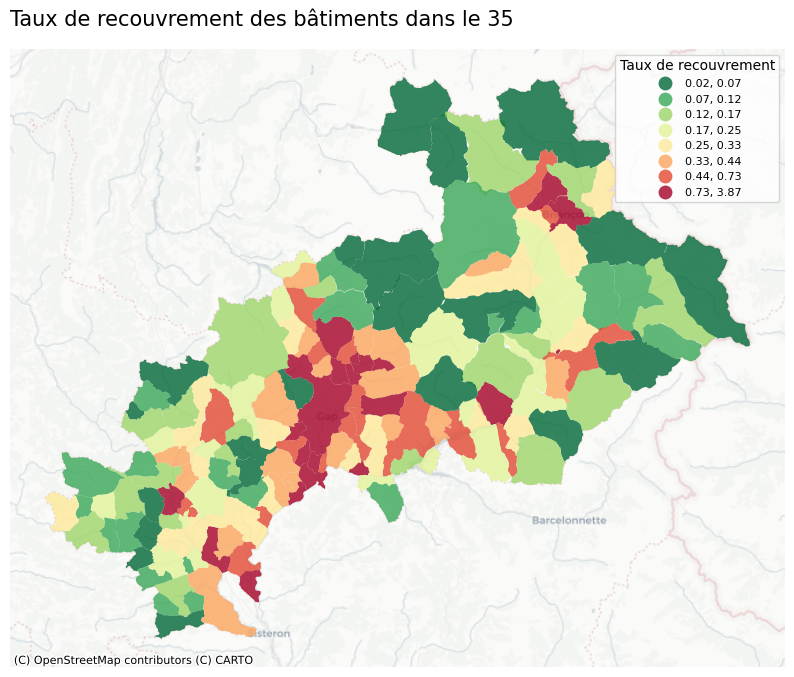

In [ ]:
# Faire la carte

Carte1, ax = plt.pyplot.subplots(figsize=(10,10))

communes.to_crs('EPSG:3857').plot(ax=ax, k=8, column="indic", cmap='RdYlGn_r',scheme='quantiles', alpha=0.8, categorical=False,
                                    legend=True, legend_kwds={'title': "Taux de recouvrement", 'loc': 'upper right', 'title_fontsize':10, 'fontsize':8})
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
ax.axis("off")
plt.pyplot.title("Taux de recouvrement des bâtiments dans le 35", loc='left', fontsize=15)


### Exercice à l'échelle des sections cadastrale


In [ ]:
# Calculer la surface des sections

sections["Surface_sections"] = sections['geometry'].area
sections["Surface_sections"]= sections["Surface_sections"].astype(int)
sections.head()

id commune prefixe code     created     updated  \
0  050010000A   05001     000    A  2006-11-01  2019-12-03   
1  050010000B   05001     000    B  2006-11-01  2019-12-03   
2  050030000A   05003     000    A  2006-11-26  2014-02-14   
3  050040000A   05004     000    A  2017-04-14  2017-05-23   
4  050060000A   05006     000    A  2016-09-21  2017-05-23   

                                            geometry  Surface_sections  
0  POLYGON ((1007707.451 6418595.634, 1007710.400...          12839552  
1  POLYGON ((1009315.792 6418632.565, 1009315.177...           1610471  
2  POLYGON ((1004822.834 6418680.779, 1004820.601...           5100321  
3  POLYGON ((952035.688 6396444.305, 952026.181 6...           2581147  
4  POLYGON ((968903.758 6414486.780, 968869.928 6...          13200604

In [ ]:
# Faire la jointure spatiale entre les batiments et les sections

BatimentsCentro = batiments.copy()
BatimentsCentro.geometry = BatimentsCentro['geometry'].centroid

Batimentssections = gpd.sjoin(BatimentsCentro, sections)
Batimentssections.head(3)

commune_left   nom type created_left updated_left  \
0        05003  None   02   2006-11-26   2014-02-14   
1        05003  None   01   2006-11-13   2014-02-14   
2        05003  None   01   2015-01-29   2015-01-29   

                          geometry  Surface_batiments  index_right  \
0  POINT (1004395.334 6419015.429)                  0            2   
1  POINT (1004468.137 6418962.664)                 20            2   
2  POINT (1004469.608 6418975.951)                 43            2   

           id commune_right prefixe code created_right updated_right  \
0  050030000A         05003     000    A    2006-11-26    2014-02-14   
1  050030000A         05003     000    A    2006-11-26    2014-02-14   
2  050030000A         05003     000    A    2006-11-26    2014-02-14   

   Surface_sections  
0           5100321  
1           5100321  
2           5100321

In [ ]:
# Calculer la somme des surfaces des bâtiments par sections cadastrales

SurfaceBatisSections= Batimentssections.groupby('id').agg({'Surface_batiments':'sum'})
SurfaceBatisSections.head()

Surface_batiments
id                           
050010000A                615
050010000B                142
050010000C                193
050010000D               4999
050010000E                165

In [ ]:
# Jointure attributaire pour enrichir la couche des communes

sections = sections.merge(SurfaceBatisSections,left_on='id', right_on='id')
sections.head()

id commune prefixe code     created     updated  \
0  050010000A   05001     000    A  2006-11-01  2019-12-03   
1  050010000B   05001     000    B  2006-11-01  2019-12-03   
2  050030000A   05003     000    A  2006-11-26  2014-02-14   
3  050040000A   05004     000    A  2017-04-14  2017-05-23   
4  050060000A   05006     000    A  2016-09-21  2017-05-23   

                                            geometry  Surface_sections  \
0  POLYGON ((1007707.451 6418595.634, 1007710.400...          12839552   
1  POLYGON ((1009315.792 6418632.565, 1009315.177...           1610471   
2  POLYGON ((1004822.834 6418680.779, 1004820.601...           5100321   
3  POLYGON ((952035.688 6396444.305, 952026.181 6...           2581147   
4  POLYGON ((968903.758 6414486.780, 968869.928 6...          13200604   

   Surface_batiments  
0                615  
1                142  
2                401  
3              23066  
4                226

In [ ]:
# Créer l'indicateur de tx de recouvrement des batimenst

sections["indic"] = sections["Surface_batiments"] / sections["Surface_sections"]*100
sections.head(3)

id commune prefixe code     created     updated  \
0  050010000A   05001     000    A  2006-11-01  2019-12-03   
1  050010000B   05001     000    B  2006-11-01  2019-12-03   
2  050030000A   05003     000    A  2006-11-26  2014-02-14   

                                            geometry  Surface_sections  \
0  POLYGON ((1007707.451 6418595.634, 1007710.400...          12839552   
1  POLYGON ((1009315.792 6418632.565, 1009315.177...           1610471   
2  POLYGON ((1004822.834 6418680.779, 1004820.601...           5100321   

   Surface_batiments     indic  
0                615  0.004790  
1                142  0.008817  
2                401  0.007862

Text(0.0, 1.0, 'Taux de recouvrement des bâtiments dans le 35')

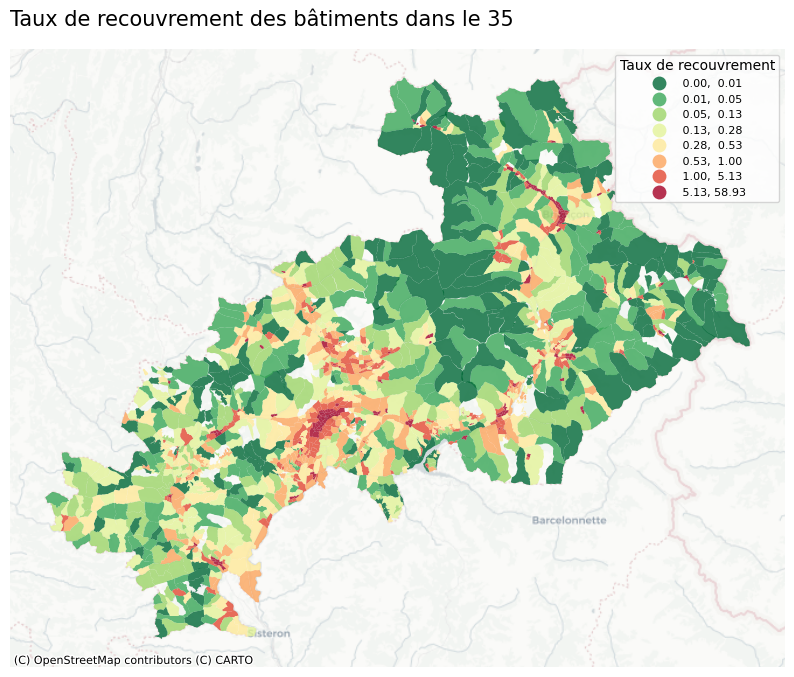

In [ ]:
# Faire la carte

Carte1, ax = plt.pyplot.subplots(figsize=(10,10))

sections.to_crs('EPSG:3857').plot(ax=ax, k=8, column="indic", cmap='RdYlGn_r',scheme='quantiles', alpha=0.8, categorical=False,
                                    legend=True, legend_kwds={'title': "Taux de recouvrement", 'loc': 'upper right', 'title_fontsize':10, 'fontsize':8})
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
ax.axis("off")
plt.pyplot.title("Taux de recouvrement des bâtiments dans le 35", loc='left', fontsize=15)
